In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import warnings
warnings.filterwarnings("ignore")

## Read data

In [2]:
data = pd.read_csv("Data/market_basket.csv")
data.head()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,1,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,2,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,3,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,4,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,5,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [3]:
data.tail()

,Unnamed: 0,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
131701,131702,04/07/2016,20203,32900,IEV,FO112,3.0,6.46
131702,131703,04/07/2016,20203,32900,N8U,I36F2,1.0,4.50
131703,131704,04/07/2016,20203,32900,U5F,4X8P4,1.0,5.19
131704,131705,04/07/2016,20203,32900,0H2,ZVTO4,1.0,4.57
131705,131706,04/07/2016,20203,32900,Q4N,QM9BP,1.0,13.68


## Clean data

In [4]:
data = data.drop("Unnamed: 0", axis = 1)
data.head()

,Date,Customer_ID,Transaction_ID,SKU_Category,SKU,Quantity,Sales_Amount
0,02/01/2016,2547,1,X52,0EM7L,1.0,3.13
1,02/01/2016,822,2,2ML,68BRQ,1.0,5.46
2,02/01/2016,3686,3,0H2,CZUZX,1.0,6.35
3,02/01/2016,3719,4,0H2,549KK,1.0,5.59
4,02/01/2016,9200,5,0H2,K8EHH,1.0,6.88


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131706 entries, 0 to 131705
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Date            131706 non-null  object 
 1   Customer_ID     131706 non-null  int64  
 2   Transaction_ID  131706 non-null  int64  
 3   SKU_Category    131706 non-null  object 
 4   SKU             131706 non-null  object 
 5   Quantity        131706 non-null  float64
 6   Sales_Amount    131706 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 7.0+ MB


In [6]:
data.describe(include=['O'])

,Date,SKU_Category,SKU
count,131706,131706,131706
unique,363,187,5242
top,23/09/2016,N8U,UNJKW
freq,638,10913,2007


In [7]:
data['Date']= pd.to_datetime(data['Date']) # change date from object to date time

In [8]:
data['Transaction_ID'].nunique()

64682

In [9]:
data['Customer_ID'].nunique()

22625

##### More than 1/2 transaction is unique and just 1/4 customer so this store doesn't received many multi-item sales.

### Take a closer look at transaction_ID and SKU

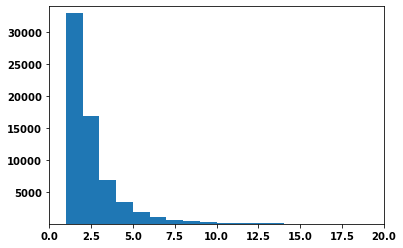

In [10]:
count = data.groupby(['Transaction_ID'])['SKU'].count().sort_values(ascending=True)
fig, ax = plt.subplots()
ax.hist(count, bins=20)
ax.set(xlim=(0,20),
      ylim=(1,34000))
plt.show()

#### 15 items that buy most 

In [11]:
most =  data.groupby(['SKU'])['Quantity'].sum().reset_index(name='Quantity').sort_values(ascending=False, 
                                                                                         by = "Quantity")
most.head(15)

,SKU,Quantity
1859,CKDW0,5769.2
4302,TD3DD,3786.0
4504,UNJKW,2179.0
2134,EEI1Q,1568.0
3370,MXKDP,1252.0
2541,H8P2L,1118.0
410,2SVKS,1113.0
1929,CYRX4,1071.0
4692,W1ZMG,1033.0
1812,C6TXL,1027.0


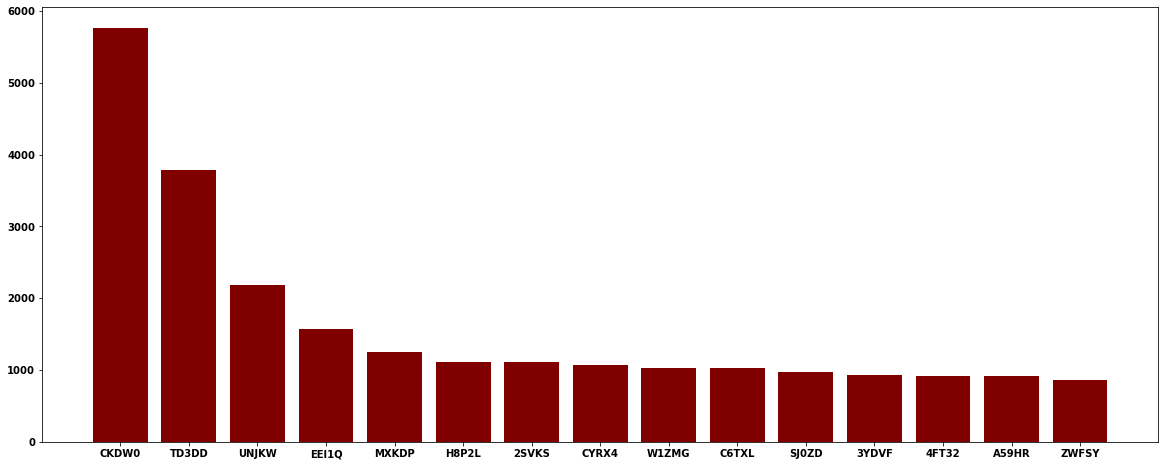

In [12]:
plt.figure(figsize = (20, 8))
plt.bar("SKU","Quantity", color ='maroon', data = most.head(15));

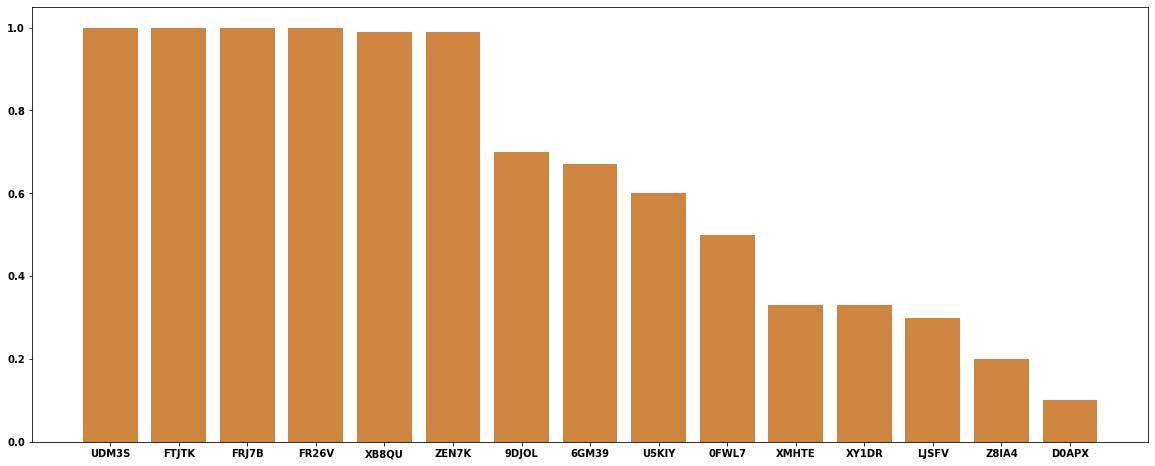

In [13]:
plt.figure(figsize = (20, 8))
plt.bar("SKU","Quantity", color ='peru', data = most.tail(15));

In [14]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

#### Grouping sku_id by transaction_ID if has many sku in one transaction_ID connect them and seperate with " "

In [15]:
grouping = data.groupby('Transaction_ID')['SKU'].apply(lambda x: ' '.join(x))

In [16]:
Transaction_list = grouping.to_list()
Transaction_list = list(map(lambda x: x.split(" ") if " " in(x) else [x] , Transaction_list))
Transaction_list[0:10]

[['0EM7L'],
 ['68BRQ'],
 ['CZUZX'],
 ['549KK'],
 ['K8EHH'],
 ['GVBRC'],
 ['AHAE7', 'AHZNS'],
 ['9STQJ'],
 ['7IE9S', 'M15RG'],
 ['UNJKW', 'KWDJZ']]

In [17]:
new_Transaction = [item for item in Transaction_list if len(item) > 1]

In [18]:
encode = TransactionEncoder()
encoding = encode.fit_transform(new_Transaction)

In [19]:
df_basket = pd.DataFrame(data = encoding, columns = encode.columns_)
df_basket

,00GVC,00OK1,0121I,01IEO,01IQT,01L05,01V7M,01XVY,029WA,03C6L,...,ZVTO4,ZWFSY,ZWWB5,ZX2UM,ZY9N9,ZYF2U,ZZDW7,ZZM1A,ZZNC5,ZZX6K
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31771,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31772,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31773,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
31774,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
df_itemset = apriori(df_basket, min_support = 0.002, use_colnames=True)

df_itemset

,support,itemsets
0,0.003399,(09LL9)
1,0.002266,(0DCAY)
2,0.004374,(0LCSZ)
3,0.004878,(0OZBT)
4,0.002518,(0PW5H)
...,...,...
342,0.007144,(ZSVWE)
343,0.004941,(ZUN8X)
344,0.004909,(ZVTO4)
345,0.002109,"(3YDVF, DWJC4)"


In [21]:
rules = association_rules(df_itemset, metric = "lift", min_threshold = 1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(3YDVF),(DWJC4),0.013878,0.017686,0.002109,0.151927,8.590118,0.001863,1.158290
1,(DWJC4),(3YDVF),0.017686,0.013878,0.002109,0.119217,8.590118,0.001863,1.119597
2,(UNJKW),(COWU2),0.047363,0.017151,0.002234,0.047176,2.750582,0.001422,1.031511
3,(COWU2),(UNJKW),0.017151,0.047363,0.002234,0.130275,2.750582,0.001422,1.095332


#### Acording to the rules table : The SUK id COWU2 going with UNJKW has the biggest support 

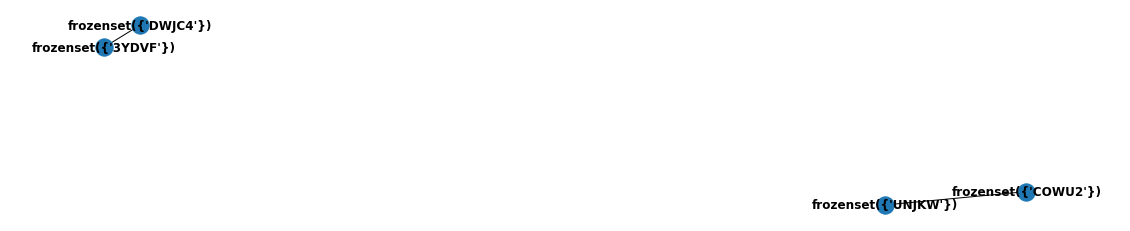

In [22]:
fig, ax = plt.subplots(figsize=(20,4))
GA = nx.from_pandas_edgelist(rules,source='antecedents',target='consequents')
nx.draw(GA,with_labels=True)
plt.show()